<img src="https://i.imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px;"/>


# DSI-SG-42

## Project Two - Regression Challenge (HDB Price)

---


### 1. Clean the test data

In [30]:
# import libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from scipy import stats
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns
import math
import warnings

# handle warnings
warnings.filterwarnings("ignore", category=FutureWarning)

# setting displays
%matplotlib inline
pd.set_option('display.width', 100000) # used during analysis
pd.set_option('display.max_rows', None) # used during analysis
pd.set_option('display.max_columns', None)


# import test data
hdb_test = pd.read_csv('../datasets/test.csv', low_memory=False)
print(hdb_test.head()) # inspect the data

       id Tranc_YearMonth         town flat_type block          street_name storey_range  floor_area_sqm         flat_model  lease_commence_date  Tranc_Year  Tranc_Month  mid_storey  lower  upper  mid            full_flat_type                   address  floor_area_sqft  price_per_sqft  hdb_age  max_floor_lvl  year_completed residential commercial market_hawker multistorey_carpark precinct_pavilion  total_dwelling_units  1room_sold  2room_sold  3room_sold  4room_sold  5room_sold  exec_sold  multigen_sold  studio_apartment_sold  1room_rental  2room_rental  3room_rental  other_room_rental  postal  Latitude   Longitude planning_area  Mall_Nearest_Distance  Mall_Within_500m  Mall_Within_1km  Mall_Within_2km  Hawker_Nearest_Distance  Hawker_Within_500m  Hawker_Within_1km  Hawker_Within_2km  hawker_food_stalls  hawker_market_stalls  mrt_nearest_distance        mrt_name  bus_interchange  mrt_interchange  mrt_latitude  mrt_longitude  bus_stop_nearest_distance bus_stop_name  bus_stop_latitude  b

### 1.1 Perform the same cleaning steps as train data

In [31]:
hdb_test['postal'] = hdb_test['postal'].astype(object) # convert 'postal' column to object

# clean up column names
hdb_test.columns = hdb_test.columns.str.strip() # remove whitespace
hdb_test.columns = hdb_test.columns.str.lower() # lowercase headers

# drop 'residential column' as there is only one value
# drop 'floor_area_sqm' as it is the same but different units to 'floor_area_sqft'
hdb_test = hdb_test.drop(columns = ['residential', 'floor_area_sqft'], axis = 1)

# convert columns to appropriate datatype

# convert id to object
hdb_test['id'] = hdb_test['id'].astype(object)

# convert all boolean integer values 
yes_no = ['commercial', 'market_hawker', 'multistorey_carpark', 'precinct_pavilion']
hdb_test[yes_no] = hdb_test[yes_no].stack().map({'Y': 1, 'N': 0}).unstack()

# inspect boolean values
print(hdb_test.head())  # debug


       id tranc_yearmonth         town flat_type block          street_name storey_range  floor_area_sqm         flat_model  lease_commence_date  tranc_year  tranc_month  mid_storey  lower  upper  mid            full_flat_type                   address  price_per_sqft  hdb_age  max_floor_lvl  year_completed  commercial  market_hawker  multistorey_carpark  precinct_pavilion  total_dwelling_units  1room_sold  2room_sold  3room_sold  4room_sold  5room_sold  exec_sold  multigen_sold  studio_apartment_sold  1room_rental  2room_rental  3room_rental  other_room_rental  postal  latitude   longitude planning_area  mall_nearest_distance  mall_within_500m  mall_within_1km  mall_within_2km  hawker_nearest_distance  hawker_within_500m  hawker_within_1km  hawker_within_2km  hawker_food_stalls  hawker_market_stalls  mrt_nearest_distance        mrt_name  bus_interchange  mrt_interchange  mrt_latitude  mrt_longitude  bus_stop_nearest_distance bus_stop_name  bus_stop_latitude  bus_stop_longitude  pri_sc

In [32]:
# Cleaning up some column headers

hdb_test = hdb_test.rename(columns = {'1room_sold': 'one_room_unit',
                                '2room_sold': 'two_room_unit',
                                '3room_sold': 'three_room_unit',
                                '4room_sold': 'four_room_unit',
                                '5room_sold': 'five_room_unit',
                                'exec_sold': 'exec_unit',
                                'multigen_sold': 'multigen_unit',
                                'studio_apartment_sold': 'studio_apartment',
                                '1room_rental': 'one_room_rental',
                                '2room_rental': 'two_room_rental',
                                '3room_rental': 'three_room_rental'
                                })

In [33]:

# define the list of top 10 schools
top_pri = ['Rosyth School', 'Nan Hua Primary School', 'Saint Hilda\'s Primary School', 'Catholic High School', 'Henry Park Primary School', 
               'Nanyang Primary School', 'Tao Nan School', 'Pei Hwa Presbyterian Primary School', 'CHIJ Saint Nicholas Girls\' School', 'Kong Hwa School']


top_pri = [x.lower() for x in top_pri] # lower case values
top_pri = [x.replace("'", '') for x in top_pri] # remove quotation marks
top_pri = [x.strip() for x in top_pri] # remove leading and trailing whitespaces
# print(top_pri) # check if changes have been made

# lower case school names in pri_sch_names
hdb_test['pri_sch_name'] = hdb_test['pri_sch_name'].str.lower()


# create a new binary list if resale unit has top school nearby
top_school = []

for school in hdb_test['pri_sch_name']:
    if any(school in top for top in top_pri):
        top_school.append(1)
    else:
        top_school.append(0)

hdb_test['nearby_top_sch'] = top_school # insert new list to df

# since hawker and mall distance intervals are the number of hawker/malls within that distance we can
# convert hawker and mall distances to int type 
malls_hawkers = ['mall_within_500m', 'mall_within_1km', 'mall_within_2km', 'hawker_within_500m', 'hawker_within_1km','hawker_within_2km']

hdb_test = hdb_test.fillna(0) # assume that there is no mall or hawker for resale flats that has NaN values

hdb_test[malls_hawkers] = hdb_test[malls_hawkers].astype(int) # convert to integer type

# check which columns have null values and count the number of null again

hdb_test.loc[:, hdb_test.isna().any()].isna().sum()


Series([], dtype: float64)

In [34]:
# Sequentially drop columns
hdb_test = hdb_test.drop(columns=['tranc_yearmonth', 'town', 'lease_commence_date', 'mid_storey', 'lower', 'upper', 'latitude', 'longitude',
                                'full_flat_type', 'address', 'year_completed', 'postal', 'block','price_per_sqft', 'street_name', 'storey_range',
                                'one_room_rental',  'two_room_rental',  'three_room_rental',  'other_room_rental'])

In [35]:
# Next we will be dropping the all boolean variables except multistorey_carpark, as it is an improvement from the open air carpark decades ago. 

hdb_test = hdb_test.drop(columns=['commercial', 'market_hawker', 'hawker_market_stalls', 'precinct_pavilion', 'cutoff_point', 'affiliation', 'vacancy'])

# Visual inspection of the first 5 rows of the df
#print(hdb_test.head()) # debug

In [36]:
# Remove all most variables related to school except pri_sch_name
# it has been selected for feature engineering

hdb_test = hdb_test.drop(columns = ['pri_sch_nearest_distance', 'pri_sch_affiliation', 'pri_sch_latitude',
                                'pri_sch_longitude', 'sec_sch_name', 'sec_sch_latitude', 'sec_sch_longitude', 'sec_sch_nearest_dist'])

# Visual inspection of the first 5 rows of the df
#print(hdb_test.head()) #debug

In [37]:
# Remove most variables from the bus/mrt related columns

hdb_test = hdb_test.drop(columns = ['mrt_latitude', 'mrt_longitude',  'bus_stop_name', 'bus_stop_latitude', 'bus_stop_longitude'])



## 2. Feature Engineering

In [38]:
# Using a for-loop to calculuate proportions for the following columns

# col = ['one_room_unit', 'two_room_unit', 'three_room_unit', 'four_room_unit', 'five_room_unit', 'exec_unit',
#         'multigen_unit', 'studio_apartment']

# Create empty lists
prop_one_room = []
prop_two_room = []
prop_three_room = []
prop_four_room = []
prop_five_room = []
prop_exec = []
prop_multigen = []
prop_studio_apt = []

# Using a for-loop to calculate the proportions and append to the empty list above
for index, room in hdb_test.iterrows():
    # one room resale
    one_room = room['one_room_unit'] / room['total_dwelling_units']  # calculate proportions
    prop_one_room.append(one_room)                                  # append to new list
    
    # two room resale
    two_room = room['two_room_unit'] / room['total_dwelling_units'] 
    prop_two_room.append(two_room)

    # three room resale
    three_room = room['three_room_unit'] / room['total_dwelling_units'] 
    prop_three_room.append(three_room)
   
    # four room resale
    four_room = room['four_room_unit'] / room['total_dwelling_units'] 
    prop_four_room.append(four_room)

    # five room resale
    five_room = room['five_room_unit'] / room['total_dwelling_units'] 
    prop_five_room.append(five_room)

    # exec resale
    exec = room['exec_unit'] / room['total_dwelling_units'] 
    prop_exec.append(exec)
    
    # multigen resale
    multigen = room['multigen_unit'] / room['total_dwelling_units'] 
    prop_multigen.append(multigen)

    # studio apt resale
    studio = room['studio_apartment'] / room['total_dwelling_units'] 
    prop_studio_apt.append(studio)  


# insert new list into df
hdb_test['prop_one_room'] = prop_one_room 
hdb_test['prop_two_room'] = prop_two_room
hdb_test['prop_three_room'] = prop_three_room
hdb_test['prop_four_room'] = prop_four_room
hdb_test['prop_five_room'] = prop_five_room
hdb_test['prop_exec'] = prop_exec
hdb_test['prop_multigen'] = prop_multigen
hdb_test['prop_studio_apt'] = prop_studio_apt


#print(hdb_test.head()) # debug

In [39]:
## Develop lists for dictionary reference
north_east=['Seletar','Punggol','Sengkang','Serangoon','Hougang','Ang Mo Kio']
north = ['Yishun','Simpang','Sembawang','Woodlands','Sungei Kadut','Mandai','Lim Chu Kang','Central Water Catchment']
west = ['Western Water Catchment','Choa Chu Kang','Bukit Panjang','Bukit Batok','Tengah','Jurong West','Jurong East','Boon Lay','Pioneer','Clementi','Tuas']
central = ['Bukit Timah','Queenstown','Bukit Merah','Tanglin','Bishan','Novena','Toa Payoh','Geylang','Marine Parade','Kallang', 'Rochor','Downtown Core','Outram','River Valley','Orchard','Newton']
east = ['Bedok','Paya Lebar','Pasir Ris','Tampines','Changi']


# Dictionary for reference
regions = {"North East":north_east, 'North':north,'West' :west,'East':east,'Central': central}

# create a function to locate region
def region_locator(area):
    for name,region in regions.items():
        if area in region:
            return name

# Mapping new column onto dataframe
hdb_test['region'] = hdb_test['planning_area'].map(region_locator)

print(hdb_test.head()) # debug

       id flat_type  floor_area_sqm         flat_model  tranc_year  tranc_month  mid  hdb_age  max_floor_lvl  multistorey_carpark  total_dwelling_units  one_room_unit  two_room_unit  three_room_unit  four_room_unit  five_room_unit  exec_unit  multigen_unit  studio_apartment planning_area  mall_nearest_distance  mall_within_500m  mall_within_1km  mall_within_2km  hawker_nearest_distance  hawker_within_500m  hawker_within_1km  hawker_within_2km  hawker_food_stalls  mrt_nearest_distance        mrt_name  bus_interchange  mrt_interchange  bus_stop_nearest_distance                       pri_sch_name  nearby_top_sch  prop_one_room  prop_two_room  prop_three_room  prop_four_room  prop_five_room  prop_exec  prop_multigen  prop_studio_apt      region
0  114982    4 ROOM            84.0         Simplified        2012           11    8       34             12                    0                   132              0              0                0              92              40          0        

In [40]:
# Feature engineer mrt

# lists of stations that sit on the respective lines
# interchange stations appear more than 1 list
north_south_line=['Jurong East','Bukit Batok','Bukit Gombak','Choa Chu Kang','Yew Tee','Kranji','Marsiling','Woodlands','Admiralty','Sembawang','Canberra','Yishun','Khatib','Yio Chu Kang','Ang Mo Kio','Bishan','Braddell','Toa Payoh','Novena','Newton','Orchard','Somerset','Dhoby Ghaut','City Hall','Raffles Place','Marina Bay','Marina South Pier']

north_east_line = ['HarbourFront','Outram Park','Chinatown','Clarke Quay','Little India','Farrer Park','Boon Keng','Potong Pasir','Woodleigh','Serangoon','Kovan','Hougang','Buangkok','Hougang','Sengkang','Punggol']

east_west_line = ['Tuas Link','Tuas West Road','Tuas Crescent','Gul Circle','Joo Koon','Pioneer','Boon Lay','Lakeside','Chinese Garden','Jurong East','Clementi','Dover','Bouna Vista','Commonwealth','Queenstown','Redhill','Tiong Bahru','Outram Park','Tanjong Pagar','Shenton Way','Raffles Place','City Hall','Bugis','Lavender','Kallang','Aljunied','Paya Lebar','Eunos','Kembangan','Bedok','Tanah Merah','Simei','Tampines','Pasir Ris','Expo','Changi Airport']

circle_line = ['HabourFront','Telok Blangah','Labrador Park','Pasir Panjang','Haw Par Villa','Kent Ridge','one-north','Bouna Vista','Holland Village','Farrer Road','Botanic Gardens','Caldecott','Marymount','Bishan','Lorong Chuan','Serangoon','Bartley','Tai Seng','MacPerson','Paya Lebar','Dakota','Mountbatten','Stadium','Nicoll Highway','Promenade','Esplanade','Bras Basah','Dhoby Ghaut']

down_town_line = ['Bukit Panjang','Cashew','Hillview','Beauty World','King Albert Park','Sixth Avenue','Tan Kah Kee','Botanic Gardens','Stevens','Newton','Little India','Rochor','Promenade','Bayfront','Downtown','Telok Ayer','Chinatown','Fort Canning','Bencoolen','Jalan Besar','Bendemeer','Geylang Bahru','Matter','MacPherson','Ubi','Kaki Bukit','Bedok North','Bedok Reservoir','Tampines West','Tampines','Tampines East','Upper Changi','Changi Airport']

thomson_east_coast_line =['Woodlands North','Woodlands','Woodlands South','Springleaf','Lentor','Mayflower','Bright Hill','Upper Thomson','Caldecott','Stevens','Napier','Orchard Boulevard','Orchard','Great World','Havelock','Outram Park','Maxwell','Shenton Way','Marina Bay','Gardens by the Bay']

# create a dictionary
mrts = {"North South Line":north_south_line, 'North East line':north_east_line,'East West Line' :east_west_line,'Circle Line':circle_line,'Down Town Line': down_town_line,'Thomson East Coast Line':thomson_east_coast_line}

# create a function to insert boolean values
def test_mrt(row):
        if row in station:
            return 1
        else:
            return 0
        
# insert the values in the dataframe
for name,station in mrts.items():
    hdb_test[f'{name}'] = hdb_test['mrt_name'].apply(test_mrt)


print(hdb_test.head()) # debug

       id flat_type  floor_area_sqm         flat_model  tranc_year  tranc_month  mid  hdb_age  max_floor_lvl  multistorey_carpark  total_dwelling_units  one_room_unit  two_room_unit  three_room_unit  four_room_unit  five_room_unit  exec_unit  multigen_unit  studio_apartment planning_area  mall_nearest_distance  mall_within_500m  mall_within_1km  mall_within_2km  hawker_nearest_distance  hawker_within_500m  hawker_within_1km  hawker_within_2km  hawker_food_stalls  mrt_nearest_distance        mrt_name  bus_interchange  mrt_interchange  bus_stop_nearest_distance                       pri_sch_name  nearby_top_sch  prop_one_room  prop_two_room  prop_three_room  prop_four_room  prop_five_room  prop_exec  prop_multigen  prop_studio_apt      region  North South Line  North East line  East West Line  Circle Line  Down Town Line  Thomson East Coast Line
0  114982    4 ROOM            84.0         Simplified        2012           11    8       34             12                    0               

In [41]:
# Calculate the floor density of each row

floor_density = []

for index, room in hdb_test.iterrows():
    temp = math.ceil(room['total_dwelling_units'] / room['max_floor_lvl'])
    floor_density.append(temp)

hdb_test['floor_density'] = floor_density

#print(hdb_test.head()) # debug
    

In [42]:
# Deriving if the unit is on the lower, middle, or upper floors

floor_category = []
floor_type = []

for index, room in hdb_test.iterrows():
    max_floor = room['max_floor_lvl']

    lower = max_floor//3
    middle = max_floor//3 * 2
    upper = max_floor//3 * 3

    if room['mid'] < lower:
        floor_category.append(1)
        floor_type.append('lower')
    
    elif room['mid'] >= middle:
        floor_category.append(3)
        floor_type.append('upper')

    else:
        floor_category.append(2)
        floor_type.append('middle')


hdb_test['floor_category'] = floor_category
#hdb_test['floor_type'] = floor_type # optional use as an object


In [43]:
# Drop the cols that were used in feature engineering

col = ['total_dwelling_units', 'one_room_unit', 'two_room_unit', 'three_room_unit', 'four_room_unit', 'five_room_unit', 'exec_unit',
        'multigen_unit', 'studio_apartment', 'hawker_food_stalls', 'mid', 'mall_nearest_distance', 'mall_within_500m', 
        'mall_within_1km', 'hawker_nearest_distance', 'hawker_within_500m', 'hawker_within_1km', 'mrt_interchange', 'bus_stop_nearest_distance']


hdb_test = hdb_test.drop(columns=col)

In [44]:
# check final df shape and inspect first 5 rows prior to one-hot encoding
print(hdb_test.shape)
print()
print(hdb_test.head())
print()
print(hdb_test.info())

(16737, 34)

       id flat_type  floor_area_sqm         flat_model  tranc_year  tranc_month  hdb_age  max_floor_lvl  multistorey_carpark planning_area  mall_within_2km  hawker_within_2km  mrt_nearest_distance        mrt_name  bus_interchange                       pri_sch_name  nearby_top_sch  prop_one_room  prop_two_room  prop_three_room  prop_four_room  prop_five_room  prop_exec  prop_multigen  prop_studio_apt      region  North South Line  North East line  East West Line  Circle Line  Down Town Line  Thomson East Coast Line  floor_density  floor_category
0  114982    4 ROOM            84.0         Simplified        2012           11       34             12                    0        Yishun                4                  1            686.660434        Canberra                0       ahmad ibrahim primary school               0            0.0            0.0         0.000000        0.696970        0.303030   0.000000            0.0              0.0       North                 1    

In [45]:
# Dummify columns

hdb_test = pd.get_dummies(data= hdb_test, columns = ['flat_type'],drop_first=True)

hdb_test = pd.get_dummies(data= hdb_test, columns = ['flat_model'])

hdb_test = pd.get_dummies(data= hdb_test, columns = ['region'],drop_first=True)
print(hdb_test.head()) # debug



       id  floor_area_sqm  tranc_year  tranc_month  hdb_age  max_floor_lvl  multistorey_carpark planning_area  mall_within_2km  hawker_within_2km  mrt_nearest_distance        mrt_name  bus_interchange                       pri_sch_name  nearby_top_sch  prop_one_room  prop_two_room  prop_three_room  prop_four_room  prop_five_room  prop_exec  prop_multigen  prop_studio_apt  North South Line  North East line  East West Line  Circle Line  Down Town Line  Thomson East Coast Line  floor_density  floor_category  flat_type_2 ROOM  flat_type_3 ROOM  flat_type_4 ROOM  flat_type_5 ROOM  flat_type_EXECUTIVE  flat_type_MULTI-GENERATION  flat_model_Adjoined flat  flat_model_Apartment  flat_model_DBSS  flat_model_Improved  flat_model_Improved-Maisonette  flat_model_Maisonette  flat_model_Model A  flat_model_Model A-Maisonette  flat_model_Model A2  flat_model_Multi Generation  flat_model_New Generation  flat_model_Premium Apartment  flat_model_Premium Apartment Loft  flat_model_Premium Maisonette  fla

# 3. Train Linear Regression Model

In [46]:
# import cleaned csv file from 2.Feature Engineering
hdb = pd.read_csv('../datasets/hdb_cleaned2.csv', index_col=0, low_memory=False)

# inspect dataframe
print(hdb.head())  

       id  floor_area_sqm  resale_price  tranc_year  tranc_month  hdb_age  max_floor_lvl  multistorey_carpark planning_area  mall_within_2km  hawker_within_2km  mrt_nearest_distance     mrt_name  bus_interchange                           pri_sch_name  nearby_top_sch  prop_one_room  prop_two_room  prop_three_room  prop_four_room  prop_five_room  prop_exec  prop_multigen  prop_studio_apt  North South Line  North East line  East West Line  Circle Line  Down Town Line  Thomson East Coast Line  floor_density  floor_category  flat_type_2 ROOM  flat_type_3 ROOM  flat_type_4 ROOM  flat_type_5 ROOM  flat_type_EXECUTIVE  flat_type_MULTI-GENERATION  flat_model_Adjoined flat  flat_model_Apartment  flat_model_DBSS  flat_model_Improved  flat_model_Improved-Maisonette  flat_model_Maisonette  flat_model_Model A  flat_model_Model A-Maisonette  flat_model_Model A2  flat_model_Multi Generation  flat_model_New Generation  flat_model_Premium Apartment  flat_model_Premium Apartment Loft  flat_model_Premium 

In [47]:
id_col = hdb_test['id'] # will be needed to merge with predicted values for Kaggle submission

hdb_test = hdb_test.drop(columns = ['id', 'planning_area', 'mrt_name', 'pri_sch_name']) # drop columns used for feature engineering

print(hdb_test.head()) # debug

   floor_area_sqm  tranc_year  tranc_month  hdb_age  max_floor_lvl  multistorey_carpark  mall_within_2km  hawker_within_2km  mrt_nearest_distance  bus_interchange  nearby_top_sch  prop_one_room  prop_two_room  prop_three_room  prop_four_room  prop_five_room  prop_exec  prop_multigen  prop_studio_apt  North South Line  North East line  East West Line  Circle Line  Down Town Line  Thomson East Coast Line  floor_density  floor_category  flat_type_2 ROOM  flat_type_3 ROOM  flat_type_4 ROOM  flat_type_5 ROOM  flat_type_EXECUTIVE  flat_type_MULTI-GENERATION  flat_model_Adjoined flat  flat_model_Apartment  flat_model_DBSS  flat_model_Improved  flat_model_Improved-Maisonette  flat_model_Maisonette  flat_model_Model A  flat_model_Model A-Maisonette  flat_model_Model A2  flat_model_Multi Generation  flat_model_New Generation  flat_model_Premium Apartment  flat_model_Premium Apartment Loft  flat_model_Premium Maisonette  flat_model_Simplified  flat_model_Standard  flat_model_Terrace  flat_model_T

In [48]:
# set target and features

y = hdb['resale_price']
X = hdb.drop(columns=['resale_price', 'pri_sch_name', 'mrt_name', 'id', 'planning_area'])

# visual inspection of columns
print(X.shape) # check number of entries and columns
print(X.head()) # visual inspect features 
print(hdb_test.head())

(150634, 56)
   floor_area_sqm  tranc_year  tranc_month  hdb_age  max_floor_lvl  multistorey_carpark  mall_within_2km  hawker_within_2km  mrt_nearest_distance  bus_interchange  nearby_top_sch  prop_one_room  prop_two_room  prop_three_room  prop_four_room  prop_five_room  prop_exec  prop_multigen  prop_studio_apt  North South Line  North East line  East West Line  Circle Line  Down Town Line  Thomson East Coast Line  floor_density  floor_category  flat_type_2 ROOM  flat_type_3 ROOM  flat_type_4 ROOM  flat_type_5 ROOM  flat_type_EXECUTIVE  flat_type_MULTI-GENERATION  flat_model_Adjoined flat  flat_model_Apartment  flat_model_DBSS  flat_model_Improved  flat_model_Improved-Maisonette  flat_model_Maisonette  flat_model_Model A  flat_model_Model A-Maisonette  flat_model_Model A2  flat_model_Multi Generation  flat_model_New Generation  flat_model_Premium Apartment  flat_model_Premium Apartment Loft  flat_model_Premium Maisonette  flat_model_Simplified  flat_model_Standard  flat_model_Terrace 


Statistics for Train Data:
Mean Squared Error: 3110467769.5679345
Root Mean Squared Error: 55771.56775246626
R2 value: 0.8481239803625199
Adj R2 value: 0.8480533696767607
Cross Validation: 0.8478625728729072

      

Statistics for Test Data:
Mean Squared Error: 3123467746.220122
Root Mean Squared Error: 55887.9928626903
R2 value: 0.8495653425037801
Adj R2: 0.8492851848443259
Cross Validation: 0.8492439825525343
Intercept: 11541523.193350008
      
Coefficients:
floor_area_sqm: 3576.008878402352
tranc_year: -5633.221031218104
tranc_month: -753.9977091549749
hdb_age: -2983.4599939697355
max_floor_lvl: 5826.1692000915045
multistorey_carpark: -51735.74507973663
mall_within_2km: -492.5753593886002
hawker_within_2km: 6181.102925617347
mrt_nearest_distance: -50.78724557888563
bus_interchange: 13590.172156093491
nearby_top_sch: 57380.86797005793
prop_one_room: -117231.94948914714
prop_two_room: -72811.35738839637
prop_three_room: -41279.76118541722
prop_four_room: -52721.37622098945
prop_fiv

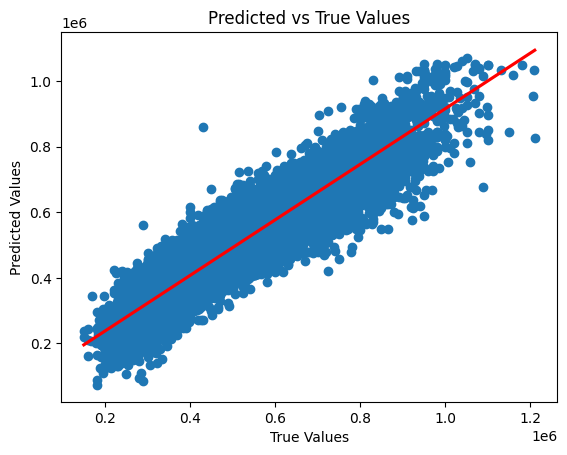

In [49]:
# Running a base Linear Regression model with engineered features

# split the data into training and test set
X_train, X_test, y_train, y_test, = train_test_split(X, y, test_size=0.2, random_state=123)

# Instantiate linear regression model
lr = LinearRegression()

# fit the training data
lr.fit(X_train, y_train)

# obtain the predicted values
y_pred_base = lr.predict(X_test)
y_pred_train_base = lr.predict(X_train)

# Obtain key statistics for train data
mse_base_train = metrics.mean_squared_error(y_train, y_pred_train_base)
r2_value_train = metrics.r2_score(y_train, y_pred_train_base)
cv_score_train_base = cross_val_score(lr, X_train, y_train, cv =5)

#display adjusted R-squared
R2_adj_lr_train = 1 - (1-lr.score(X_train, y_train))*(len(y_train)-1)/(len(y_train)-X_train.shape[1]-1)


print(f'''
Statistics for Train Data:
Mean Squared Error: {mse_base_train}
Root Mean Squared Error: {np.sqrt(mse_base_train)}
R2 value: {r2_value_train}
Adj R2 value: {R2_adj_lr_train}
Cross Validation: {cv_score_train_base.mean()}

      ''')


# Obtain key statistics for test data
mse_base = metrics.mean_squared_error(y_test, y_pred_base)
r2_value = metrics.r2_score(y_test, y_pred_base)
lr_coef = lr.coef_
lr_intercept = lr.intercept_
cv_score_base = cross_val_score(lr, X_test, y_test, cv =5)

#display adjusted R-squared
R2_adj_lr_test = 1 - (1-lr.score(X_test, y_test))*(len(y_test)-1)/(len(y_test)-X_test.shape[1]-1)

# pair the coefficients with the column names
col_names = X.columns
names_coef = list(zip(col_names, lr_coef))


print(f'''
Statistics for Test Data:
Mean Squared Error: {mse_base}
Root Mean Squared Error: {np.sqrt(mse_base)}
R2 value: {r2_value}
Adj R2: {R2_adj_lr_test}
Cross Validation: {cv_score_base.mean()}
Intercept: {lr_intercept}
      ''')
print('Coefficients:')
for features, values in names_coef:
    print(f'{features}: {values}')


# plot the predicted vs true values
plt.scatter(y_test, y_pred_base)
sns.regplot(x = y_test, y = y_pred_base, scatter=False, color='red')
plt.title('Predicted vs True Values')
plt.xlabel('True Values')
plt.ylabel('Predicted Values')

plt.show()

## 3.1 Obtain predicted values

In [50]:
y_pred_base = lr.predict(hdb_test)
#print(list(y_pred_base)) # debug
y_pred_base = pd.Series(y_pred_base) # convert to Series 
#print(type(y_pred_base)) # debug


# combined both series data
kaggle_df = pd.concat([id_col, y_pred_base], axis = 1)


[345337.93355511874, 512811.4337826837, 377033.7961808257, 304215.84706868604, 453869.7303460054, 350328.3974884115, 268489.63957211, 445760.18296915106, 318188.0086182542, 239860.44313570857, 434832.25230881013, 461736.6239812765, 643534.776315758, 372787.4695565216, 493132.9092661571, 377869.2860377766, 591341.7613583915, 681421.7172737103, 431169.24295970984, 526039.073169617, 214303.16043449193, 411686.9560289923, 264536.91302810796, 581951.7047185842, 243677.80113959685, 423068.72011835873, 319169.71525626443, 400132.76144547015, 228104.30824089795, 490838.41216640547, 264861.75223643705, 381475.1707234103, 511113.4810437504, 416859.3688942194, 219447.891554676, 457234.33105487935, 438917.180196885, 298262.71157066524, 719271.1873662956, 669527.1470550541, 706957.6067157108, 301692.44198943675, 460798.18111901544, 362003.4134270735, 723409.7517451681, 538467.0030724369, 359059.2800933942, 435598.607559029, 654173.2038993109, 414838.0875954721, 460299.2812131196, 372312.56414765865

In [405]:
# Export to csv
kaggle_df.to_csv('../datasets/kaggle_CRT.csv', index = False)